# Light curves augmentation using neural networks

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import warnings
warnings.filterwarnings('ignore', 'lbfgs failed to converge*')

import aug_functions
import utils

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex', preamble='''
        \\usepackage[utf8]{inputenc}
        \\usepackage{amssymb}
        \\usepackage{amsfonts}
        \\usepackage[russian]{babel}''')

### Data download

In [3]:
good_objects_df = pd.read_csv("../data/plasticc/good_objects.csv", index_col=0)
good_objects_df.sample(10)

,object_id,mjd,passband,flux,flux_err,detected,log_lam,class
411679,207549,59896.1384,1,9.097641,0.720817,1,3.675929,1
437616,13650,59902.1537,3,22.544109,1.968555,1,3.875155,0
263118,131815,60209.1965,3,154.582977,2.038811,1,3.875155,1
4383333,139876,60184.3625,2,44.515747,2.177522,1,3.790512,0
6139354,194243,59867.1862,4,20.569077,2.513232,1,3.938479,1
128131,67898,59854.0950,3,207.598343,1.891999,1,3.875155,0
7704533,243779,60076.9969,3,8.290128,1.159386,1,3.875155,0
6836128,216090,60609.0721,2,13.452399,0.646220,1,3.790512,0
7823862,247597,60549.1256,5,91.979630,6.514686,1,3.987288,1
3784923,121287,60224.0217,1,18.624050,1.092981,1,3.675929,1


In [4]:
good_object_ids = np.unique(good_objects_df.object_id)

### An example of augmentation model work

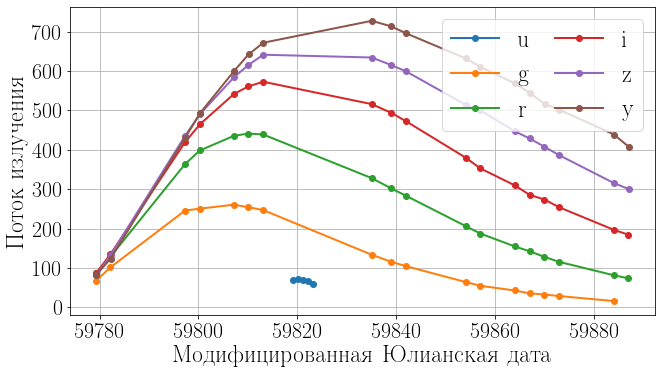

In [5]:
anobject = aug_functions.get_object(good_objects_df, 34299)

aug_functions.plot_light_curves(anobject)

In [6]:
anobject.head()

,object_id,mjd,passband,flux,flux_err,detected,log_lam,class
65498,34299,59779.3188,2,87.794540,2.394942,1,3.790512,0
65499,34299,59779.3265,1,68.224197,2.879688,1,3.675929,0
65500,34299,59779.3342,3,87.452316,2.326311,1,3.875155,0
65501,34299,59779.3452,4,81.765785,3.025279,1,3.938479,0
65502,34299,59779.3562,5,82.755684,7.136933,1,3.987288,0


In [7]:
augmentation_model = "BNN"

RMSE:  15.018131524464788
MAE:  12.827002805139418
RSE:  0.07580328345960327
RAE:  0.07324949928847688
MAPE:  8.752511606927785


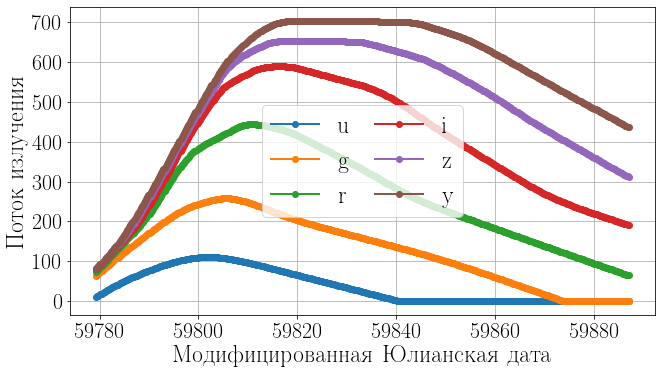

In [8]:
from sklearn.model_selection import train_test_split

# train/test split data
anobject = aug_functions.get_object(good_objects_df, 34299)
anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)

# select augmentation model
model = None
if augmentation_model == "GP":
    import gp_aug
    model = gp_aug.GaussianProcessesAugmentation(aug_functions.passband2lam)
elif augmentation_model == "NN_1":
    import single_layer_aug
    model = single_layer_aug.SingleLayerNetAugmentation(aug_functions.passband2lam)
elif augmentation_model == "FE":
    import features_aug
    model = features_aug.FeaturesEngineeringAugmentation(aug_functions.passband2lam)
elif augmentation_model == "MLP":
    import mlp_aug
    model = mlp_aug.MLPRegressionAugmentation(aug_functions.passband2lam)
elif augmentation_model == "RBF":
    import rbfnet_aug
    model = rbfnet_aug.RBFNetAugmentation(aug_functions.passband2lam)
elif augmentation_model == "BNN":
    import bnn_aug
    model = bnn_aug.BayesianNetAugmentation(aug_functions.passband2lam)
else:
    raise ValueError("Unknown augmentation type: {}".format(augmentation_model))
    
# fit augmentation model
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

# predict flux for unseen observations
flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)

# augmentation
t_aug, flux_aug, flux_err_aug, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                  anobject['mjd'].max(), 
                                                                  n_obs=aug_functions.N_OBS)
anobject_test_pred = anobject_test.copy()
anobject_test_pred['flux'], anobject_test_pred['flux_err'] = flux_pred, flux_err_pred

# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'])
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

# visualize augmented light curve
anobject_aug = aug_functions.compile_obj(t_aug, flux_aug, flux_err_aug, passbands_aug)
anobject_aug["object_id"] = anobject.object_id.to_numpy()[0]
aug_functions.plot_light_curves(anobject_aug, "aug")

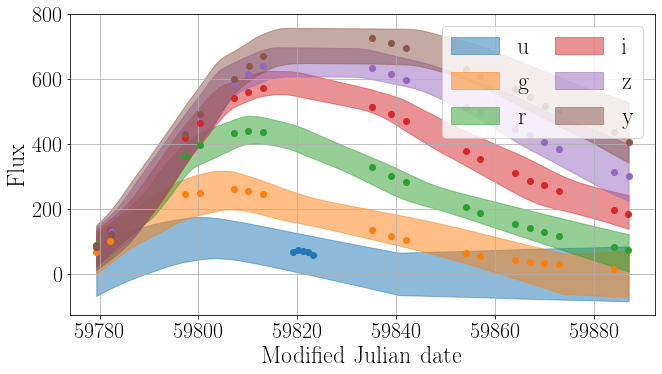

In [9]:
anobject_pic_real = anobject.sort_values('mjd')
anobject_pic_aug = anobject_aug.sort_values('mjd')
colors = ['C' + str(i) for i in range(6)]

fig = plt.figure(figsize=(9, 5), tight_layout = {'pad': 0})
for passband in range(6):
    light_curve_real = aug_functions.get_passband(anobject_pic_real, passband)
    light_curve_aug = aug_functions.get_passband(anobject_pic_aug, passband)
    plt.plot(light_curve_real['mjd'].values, light_curve_real['flux'].values, 'o', linewidth=2)
    plt.fill_between(light_curve_aug['mjd'].values,
                     light_curve_aug['flux'].values - 3 * light_curve_aug['flux_err'].values,
                     light_curve_aug['flux'].values + 3 * light_curve_aug['flux_err'].values,
                     label=aug_functions.passband2name[passband], alpha=0.5, color=colors[passband])
#plt.title('Ожидаемый разброс значений $\hat{f}(x) \pm 3 \sigma$', fontsize=28, pad=8.0)
plt.xlabel('Modified Julian date', fontsize=24)
plt.xticks(fontsize=22)
plt.ylabel('Flux', fontsize=24)
plt.yticks(fontsize=22)
plt.legend(loc='upper right', ncol=2, fontsize=24, columnspacing=1.0)
plt.grid(True)
plt.show()
#fig.savefig("../pictures/light_curve_{}_{}.pdf".format(anobject.object_id.to_numpy()[0], 
#            augmentation_model), bbox_inches='tight', pad_inches=0.0)#

### Solution of the regression problem

In [10]:
from tqdm.notebook import tqdm

metrics = []
for good_id in tqdm(good_object_ids):
    # get an object
    anobject = aug_functions.get_object(good_objects_df, good_id)

    # train / test split data
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)
    
    # select augmentation model
    model = None
    if augmentation_model == "GP":
        model = gp_aug.GaussianProcessesAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "NN_1":
        model = single_layer_aug.SingleLayerNetAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "FE":
        model = features_aug.FeaturesEngineeringAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "MLP":
        model = mlp_aug.MLPRegressionAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "RBF":
        model = rbfnet_aug.RBFNetAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "BNN":
        model = bnn_aug.BayesianNetAugmentation(aug_functions.passband2lam)
    else:
        raise ValueError("Unknown augmentation type")
        
    # fil augmentation model
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    # predict flux for unseen observations
    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, 
                                             anobject_test['passband'].values, copy=True)

    # calculate metrics
    metrics.append(utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                           flux_pred.reshape((1, -1))[0]))

df_metrics = pd.DataFrame(data=metrics, columns=["RMSE", "MAE", "RSE", "RAE", "MAPE"])
df_metrics.mean()

  0%|          | 0/2508 [00:00<?, ?it/s]

RMSE    21.712842
MAE     13.907672
RSE      0.317857
RAE      0.281384
MAPE    18.655916
dtype: float64

In [11]:
# sample metric values

rmse = np.array(metrics)[:,0]
mae = np.array(metrics)[:,1]
rse = np.array(metrics)[:,2]
rae = np.array(metrics)[:,3]
mape = np.array(metrics)[:,4]

N = len(good_object_ids)
assert len(rmse) == N
assert len(mae) == N
assert len(rse) == N
assert len(rae) == N
assert len(mape) == N

sample_coeffs = np.random.randint(0, N, (10000, 1000))

# calculate mean RMSE
sample_rmse = rmse[sample_coeffs]
sample_rmse_mean = sample_rmse.mean(axis=1)
print("RMSE: mean = %.4f, std = %.4f" % (sample_rmse_mean.mean(), sample_rmse_mean.std()))

# calculate mean MAE
sample_mae = mae[sample_coeffs]
sample_mae_mean = sample_mae.mean(axis=1)
print("MAE:  mean = %.4f, std = %.4f" % (sample_mae_mean.mean(), sample_mae_mean.std()))

# calculate mean RSE
sample_rse = rse[sample_coeffs]
sample_rse_mean = sample_rse.mean(axis=1)
print("RSE:  mean = %.4f,  std = %.4f" % (sample_rse_mean.mean(), sample_rse_mean.std()))

# calculate mean RAE
sample_rae = rae[sample_coeffs]
sample_rae_mean = sample_rae.mean(axis=1)
print("RAE:  mean = %.4f,  std = %.4f" % (sample_rae_mean.mean(), sample_rae_mean.std()))

# calculate mean MAPE
sample_mape = mape[sample_coeffs]
sample_mape_mean = sample_mape.mean(axis=1)
print("MAPE: mean = %.4f, std = %.4f" % (sample_mape_mean.mean(), sample_mape_mean.std()))

RMSE: mean = 21.6857, std = 8.1169
MAE:  mean = 13.8948, std = 4.9047
RSE:  mean = 0.3178,  std = 0.0055
RAE:  mean = 0.2813,  std = 0.0046
MAPE: mean = 18.6551, std = 0.3445


### Solution of the classification problem

In [12]:
from tqdm.notebook import tqdm

all_data = []
all_target_classes = []
for good_id in tqdm(good_object_ids):
    # train / test split data
    anobject = aug_functions.get_object(good_objects_df, good_id)
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

    # initialize augmentation model
    model = None
    if augmentation_model == "GP":
        model = gp_aug.GaussianProcessesAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "NN_1":
        model = single_layer_aug.SingleLayerNetAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "FE":
        model = features_aug.FeaturesEngineeringAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "MLP":
        model = mlp_aug.MLPRegressionAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "RBF":
        model = rbfnet_aug.RBFNetAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "BNN":
        model = bnn_aug.BayesianNetAugmentation(aug_functions.passband2lam)
    else:
        raise ValueError("Unknown augmentation type")

    # fit augmentation model
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    # predict flux for unseen observations
    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, 
                                             anobject_test['passband'].values, copy=True)

    # augmentation
    t_aug, flux_aug, flux_err_aug, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                      anobject['mjd'].max(), 
                                                                      n_obs=aug_functions.N_OBS)

    # convert values to 2D-array
    data_array = flux_aug.reshape((aug_functions.N_PASSBANDS, aug_functions.N_OBS)).T
    all_data.append([data_array])
    
    # add target value for this curve
    true_class = int(anobject['class'].to_numpy()[0])
    all_target_classes.append(true_class)
    
# collect all input data
all_data = np.array(all_data)
all_target_classes = np.array(all_target_classes)
print(all_data.shape, all_target_classes.shape)

  0%|          | 0/2508 [00:00<?, ?it/s]

(2508, 1, 500, 6) (2508,)


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

device = 'cpu'

In [14]:
# train / test split data
X_train, X_test, y_train, y_test = train_test_split(all_data, 
                                                    all_target_classes,
                                                    test_size=0.4,
                                                    random_state=179)

# normalize input data
X_train_norm = np.array((X_train - X_train.mean()) / X_train.std(), dtype=np.float32)
X_test_norm = np.array((X_test - X_train.mean()) / X_train.std(), dtype=np.float32)

# convert train data to tensors
X_train_tensor = torch.from_numpy(X_train_norm)
y_train_tensor = torch.from_numpy(np.array(y_train, dtype=np.float32))

# create train data loader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=1,
                                          shuffle=True, num_workers=2)

# convert test data to tensors
X_test_tensor = torch.from_numpy(X_test_norm)
y_test_tensor = torch.from_numpy(np.array(y_test, dtype=np.float32))

# create test data loader
test_data = TensorDataset(X_test_tensor, y_test_tensor)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1,
                                         shuffle=False, num_workers=2)

In [15]:
# model for binary classificiation: Supernova Ia VS others

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=(10, 2))
        self.conv2 = nn.Conv2d(4, 8, kernel_size=(10, 2))
        self.conv3 = nn.Conv1d(8, 16, kernel_size=(5, 2))
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(3824, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = x.view(-1, 3824)
        
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [16]:
import torch.optim as optim

# initialize binary classifier
net = Net()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [17]:
def get_model_accuracy(net, data_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for test_info in data_loader:
            images, test_labels = test_info
            test_outputs = net(images)
            prob = test_outputs.item()
            if prob > 0.5:
                predicted = 1
            else:
                predicted = 0
            total += test_labels.size(0)
            correct += (predicted == test_labels.item())

    return correct / total

In [18]:
epochs = np.arange(100)

best_loss = float('inf')
best_state = None

for epoch in tqdm(epochs):  # loop over the dataset multiple times
    epoch_loss = 0.0
    for info in trainloader:
        # get the inputs; info is a list of [inputs, labels]
        inputs, labels = info

        # zero the parameter gradients
        for param in net.parameters():
            param.grad = None
        
        # forward + backward + optimize
        outputs = net(inputs).reshape(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # print mean loss for the epoch
    cur_loss = epoch_loss / X_train_norm.shape[0]
    if (epoch + 1) % 10 == 0:
        print('[%5d] error: %.3f' % (epoch + 1, cur_loss))
    if cur_loss <= best_loss:
        best_loss = cur_loss
        best_state = net.state_dict()

net.load_state_dict(best_state)

print('Finished Training')

  0%|          | 0/100 [00:00<?, ?it/s]

[   10] error: 0.686
[   20] error: 0.685
[   30] error: 0.588
[   40] error: 0.229
[   50] error: 0.180
[   60] error: 0.145
[   70] error: 0.188
[   80] error: 0.146
[   90] error: 0.261
[  100] error: 0.133
Finished Training


In [19]:
# check models' accuracy
test_accuracy = get_model_accuracy(net, testloader)
train_accuracy = get_model_accuracy(net, trainloader)

print('Test accuracy of the network on the %d test images: %.4f' % 
      (X_test_norm.shape[0], test_accuracy))
print('Train accuracy of the network on the %d train images: %.4f' % 
      (X_train_norm.shape[0], train_accuracy))

Test accuracy of the network on the 1004 test images: 0.9353
Train accuracy of the network on the 1504 train images: 0.9435


In [20]:
y_test = []
y_probs = []
y_probs_0 = []
y_probs_1 = []

with torch.no_grad():
    for test_info in testloader:
        images, test_labels = test_info
        test_outputs = net(images)
        
        # get output value
        prob = test_outputs.item()
        
        # check true target valur    
        true_class = int(test_labels.item())
        
        # compare output to threshold
        if true_class == 0:
            y_probs_0.append(prob)
        else:
            y_probs_1.append(prob)
        
        # get predicted target value
        y_test.append(true_class)
        y_probs.append(prob)
        
y_test = np.array(y_test)
y_probs = np.array(y_probs)

assert np.array(y_probs).min() >= 0
assert np.array(y_probs).max() <= 1

In [21]:
N = len(y_probs)

# sample predicted values
sample_coeffs = np.random.randint(0, N, (10000, 1000))
sample_prob = y_probs[sample_coeffs]
sample_test = y_test[sample_coeffs]
sample_pred = sample_prob > 0.5

assert len(sample_test) == len(sample_prob)
assert len(sample_prob) == len(sample_pred)
T = len(sample_test)

# calculated mean accuracy
accuracy = [(sample_pred[i] == sample_test[i]).mean() for i in range(T)]

In [22]:
from sklearn.metrics import log_loss

y_pred = np.array(y_probs) > 0.5
print("LogLoss = %.4f" % log_loss(y_test, y_pred))

# calculate mean log loss
logloss = [log_loss(sample_test[i], sample_pred[i]) for i in range(T)]

LogLoss = 2.3737


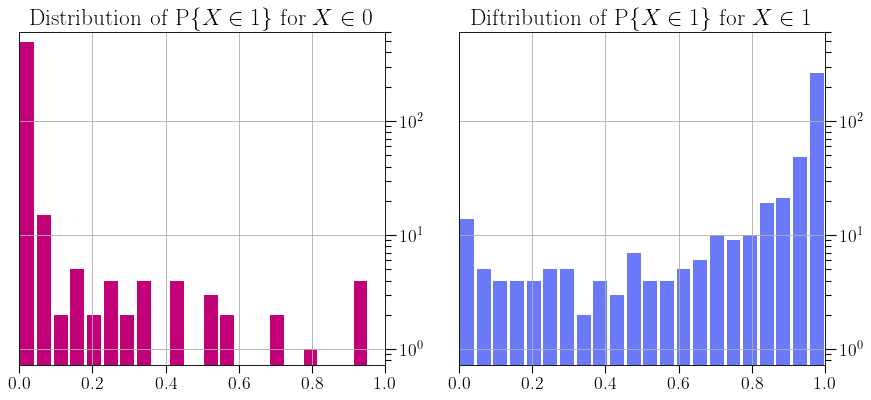

In [23]:
# compare distibution of output values

rc('xtick', labelsize=16)
rc('ytick', labelsize=16)

fig = plt.figure(dpi=80, figsize=(13, 5.5))

bins_number = 22
step = 1 / bins_number
hist_0, _ = np.histogram(y_probs_0, bins=bins_number, range=(0.0, 1.0))
hist_1, _ = np.histogram(y_probs_1, bins=bins_number, range=(0.0, 1.0))
x = np.arange(0 + step/2, 1, step)

ax1 = fig.add_subplot(121)
ax1.yaxis.tick_right()
plt.title("Distribution of P$\{X \in 1\}$ for $X \in 0$", fontsize=21, pad=7)

ax1.bar(x, hist_0, color="xkcd:magenta", width=0.038, log=True)
ax1.minorticks_on()
ax1.tick_params('y', length=10, width=1, which='major')
ax1.tick_params('y', length=5, width=1, which='minor')
ax1.tick_params('x', length=7, width=1, which='major')
ax1.tick_params('x', length=0, width=1, which='minor')
plt.xlim((0.0, 1.0))
plt.ylim((ax1.get_ylim()[0], int(ax1.get_ylim()[1]) // 100 * 100))
plt.grid(True)

ax2 = fig.add_subplot(122)
ax2.yaxis.tick_right()
plt.title("Diftribution of P$\{X \in 1\}$ for $X \in 1$", fontsize=21, pad=7)

ax2.bar(x, hist_1, color="xkcd:cornflower", width=0.038, log=True)
ax2.minorticks_on()
ax2.tick_params('y', length=10, width=1, which='major')
ax2.tick_params('y', length=5, width=1, which='minor')
ax2.tick_params('x', length=7, width=1, which='major')
ax2.tick_params('x', length=0, width=1, which='minor')
plt.xlim((0.0, 1.0))
plt.ylim(ax1.get_ylim())
plt.grid(True)

plt.show()

#fig.savefig("../pictures/CNN_output_hist_2_{}.pdf".format(augmentation_model),
#           bbox_inches='tight')

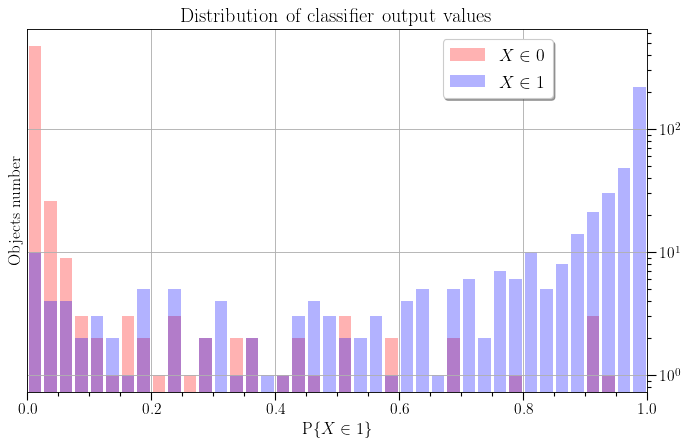

In [24]:
# compare distibution of output values

rc('xtick', labelsize=14)
rc('ytick', labelsize=14)

fig = plt.figure(dpi=80, figsize=(10, 6))
ax = fig.add_subplot(111)
ax.yaxis.tick_right()

plt.title("Distribution of classifier output values", fontsize=18, pad=7)
plt.xlabel("P$\{X \in 1\}$", fontsize=15)
plt.ylabel("Objects number", fontsize=15)

bins_number = 40
step = 1 / bins_number
hist_0, _ = np.histogram(y_probs_0, bins=bins_number, range=(0.0, 1.0))
hist_1, _ = np.histogram(y_probs_1, bins=bins_number, range=(0.0, 1.0))
x = np.arange(0 + step/2, 1, step)

plt.bar(x, hist_0, color='r', width=0.02, log=True, label="$X \in 0$", alpha=0.3)
plt.bar(x, hist_1, color='b', width=0.02, log=True, label="$X \in 1$", alpha=0.3)

ax.minorticks_on()
ax.tick_params('y', length=8, width=1, which='major')
ax.tick_params('y', length=4, width=1, which='minor')
ax.tick_params('x', length=7, width=1, which='major')
ax.tick_params('x', length=4, width=1, which='minor')

plt.xlim((0.0, 1.0))
plt.grid(True)
plt.legend(frameon=True, loc=(0.67, 0.81), fontsize=16, shadow=0.1)

plt.show()

#fig.savefig("../pictures/CNN_output_hist_1_{}.pdf".format(augmentation_model),
#           bbox_inches='tight', pad_inches=0.01)

Test ROC-AUC: 0.9859, test PR-AUC: 0.9849


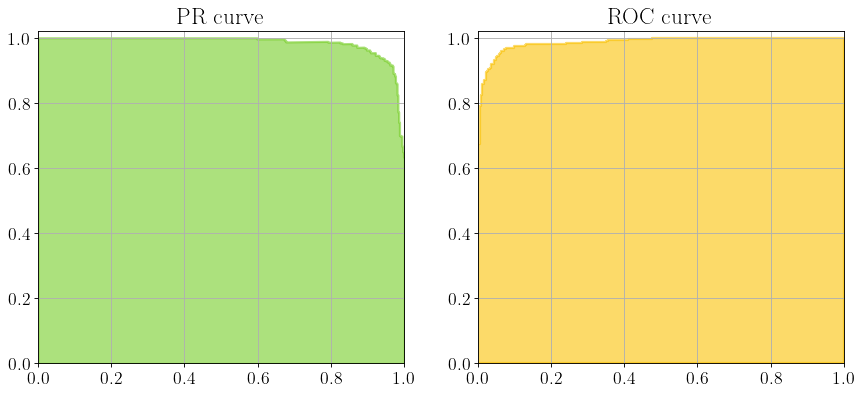

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

rc('xtick', labelsize=16)
rc('ytick', labelsize=16)

print("Test ROC-AUC: %.4f, test PR-AUC: %.4f" % (roc_auc_score(y_test, y_probs), 
                                                 average_precision_score(y_test, y_probs)))

# calculate mean AUC-ROC & AUC-PR
auc_roc = [roc_auc_score(sample_test[i], sample_prob[i]) for i in range(T)]
auc_pr = [average_precision_score(sample_test[i], sample_prob[i]) for i in range(T)]

precision, recall, _ = precision_recall_curve(y_test, y_probs)

fig = plt.figure(dpi=80, figsize=(13, 5.5))
ax = fig.add_subplot(121)
plt.grid(True)
ax.set_title("PR curve", fontsize=21, pad=7)
ax.fill_between(recall, precision, alpha=0.6, color="xkcd:apple green", lw=2)
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.02)

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

ax = fig.add_subplot(122)
plt.grid(True)
ax.set_title("ROC curve", fontsize=21, pad=7)
ax.fill_between(fpr, tpr, alpha=0.6, color="xkcd:goldenrod", lw=2)
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.02)

plt.show()

#fig.savefig("../pictures/CNN_pr_roc_curves_{}.pdf".format(augmentation_model), 
#            bbox_inches='tight')

In [26]:
print("LogLoss:  mean = %.4f, std = %.4f" % (np.mean(logloss), np.std(logloss)))
print("Accuracy: mean = %.4f, std = %.4f" % (np.mean(accuracy), np.std(accuracy)))
print("AUC-ROC:  mean = %.4f, std = %.4f" % (np.mean(auc_roc), np.std(auc_roc)))
print("AUC-PR:   mean = %.4f, std = %.4f" % (np.mean(auc_pr), np.std(auc_pr)))

LogLoss:  mean = 2.3740, std = 0.2758
Accuracy: mean = 0.9313, std = 0.0080
AUC-ROC:  mean = 0.9859, std = 0.0029
AUC-PR:   mean = 0.9849, std = 0.0031


### Summary metric tables for augmentation models

#### Table of the direct metrics:

|Model|RMSE         | MAE        | RSE               | RAE               | MAPE           | Time      |
|:----|:-----------:|:----------:|:-----------------:|:-----------------:|:--------------:|:---------:|
|GP   | $18$ ± $6$  | $11$ ± $3$ | $0.305$ ± $0.007$ | $\textbf{0.265}$ **±** $\textbf{0.005}$ | $20.0$ ± $0.7$ | $09$:$09$ |
|NN1  | $29$ ± $14$ | $18$ ± $7$ | $0.370$ ± $0.006$ | $0.328$ ± $0.005$ | $22.0$ ± $0.6$ | $37$:$41$ |
|FE   | $21$ ± $7$  | $12$ ± $3$ | $0.320$ ± $0.005$ | $0.279$ ± $0.005$ | $18.0$ ± $0.3$ | $45$:$46$ |
|MLP  | $\textbf{17}$ **±** $\textbf{6}$  | $\textbf{10}$ **±** $\textbf{3}$ | $0.348$ ± $0.009$ | $0.295$ ± $0.008$ | $\textbf{17.1}$ **±** $\textbf{0.5}$ | $\textbf{02}$**:**$\textbf{23}$ |
|BNN  | $22$ ± $8$  | $14$ ± $5$ | $\textbf{0.318}$ **±** $\textbf{0.006}$ | $0.281$ ± $0.005$ | $18.7$ ± $0.3$ | $45$:$48$ |

#### Table of the indirect metrics:

|Model|AUC-ROC            |AUC-PR           |Accuracy           |LogLoss        |Complexity|
|:----|:-----------------:|:---------------:|:-----------------:|:-------------:|:--------:|
|GP   | $0.986$ ± $0.003$ | $0.98$ ± $0.01$ | $0.947$ ± $0.007$ | $1.8$ ± $0.2$ | $O(N^3)$ |
|NN1  | $0.983$ ± $0.005$ | $0.97$ ± $0.01$ | $0.925$ ± $0.008$ | $2.0$ ± $0.3$ | $O(N)$   |
|FE   | $0.981$ ± $0.004$ | $0.98$ ± $0.01$ | $0.948$ ± $0.008$ | $1.9$ ± $0.3$ | $O(N)$   |
|MLP  | $\textbf{0.987}$ **±** $\textbf{0.002}$ | $0.98$ ± $0.01$ | $\textbf{0.951}$ **±** $\textbf{0.007}$ | $\textbf{1.7}$ **±** $\textbf{0.3}$ | $O(N)$   |
|BNN  | $0.986$ ± $0.003$ | $0.98$ ± $0.01$ | $0.931$ ± $0.008$ | $2.4$ ± $0.3$ | $O(N)$   |